In [1]:
import torch 
from torch import nn 
from torch.nn import functional as F 
import pdb
import math 
import numpy as np 
import time 
from dataclasses import dataclass 
from typing import Optional, Tuple, List 
import pandas as pd 
from matplotlib import pyplot as plt

# Encoder


In [21]:
device = torch.device("cuda:5") 

with open('/hpc_stor03/sjtu_home/chen.yang/study/llama3/tiny_shakespeare.txt', 'r') as f: 
 data = f.read() 

# 通过提取tiny_shakespeare数据中的所有唯一字符准备词汇表  
vocab = sorted(list(set(data))) 

# 训练Llama 3模型需要额外的标记，如<|begin_of_text|>、<|end_of_text|>和<|pad_id|>，将它们添加到词汇表中  
vocab.extend(['<|begin_of_text|>','<|end_of_text|>','<|pad_id|>']) 
vocab_size = len(vocab) 

# 创建字符与词汇表中对应整数索引之间的映射。
# 这对于构建分词器的编码和解码函数至关重要。
itos = {i:ch for i, ch in enumerate(vocab)} 
stoi = {ch:i for i, ch in enumerate(vocab)} 

# 分词器编码函数：输入字符串，输出整数列表  
def encode(s): 
 return [stoi[ch] for ch in s] 

# 分词器解码函数：输入整数列表，输出字符串  
def decode(l): 
 return ''.join(itos[i] for i in l) 

# 定义稍后在模型训练中使用的张量标记变量  
token_bos = torch.tensor([stoi['<|begin_of_text|>']], dtype=torch.int, device=device) 
token_eos = torch.tensor([stoi['<|end_of_text|>']], dtype=torch.int, device=device) 
token_pad = torch.tensor([stoi['<|pad_id|>']], dtype=torch.int, device=device) 

In [22]:
prompts = "Hello World" 
encoded_tokens = encode(prompts) 
decoded_text = decode(encoded_tokens) 
decoded_text
encoded_tokens

[20, 43, 50, 50, 53, 1, 35, 53, 56, 50, 42]

# Decoder
## RMS归一化（Root Mean Square Normalization）
RMSNorm 只计算输入的均方根，不计算均值。
这种差异使得 RMSNorm 在计算上更简单，且在一些情况下能更有效地稳定训练，特别是在自然语言处理任务中。



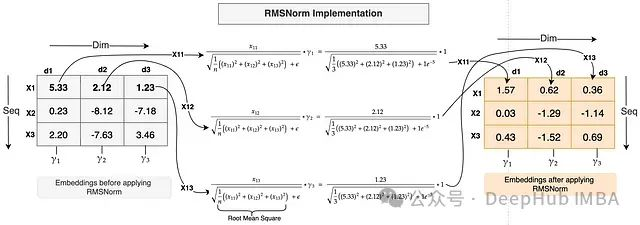



In [23]:
class ModelArgs:
    dim=512
    n_layers=8
    n_heads=8
    n_kv_heads=4
    vocab_size=len(vocab)
    multiple_of=256 #用于计算前馈网络维度
    ffn_dim_multiplier: Optional[int] = None   #用冒号指定变量类型
    norm_eps=1e-5
    rope_theta=10000.0
    
    max_batch_size=10
    max_seq_len=256
    
    epochs=2500
    log_interval=10
    device=torch.device("cuda:5") 
    
    
class RMSNorm(nn.Module):
    def __init__(self, dim, eps=1e-6):
        super().__init__()
        device=ModelArgs.device
        self.eps = eps
        self.alpha = nn.Parameter(torch.zeros(1)).to(device)#偏置
        self.gamma = nn.Parameter(torch.ones(1)).to(device) #缩放参数
        
    def _norm(self,x):  #前面带下划线的函数是私有函数
        return x*torch.rsqrt(x.pow(2).mean(dim=-1, keepdim=True) + self.eps)
    
        
    def forward(self, x):
        output = self._norm(x).type_as(x)
        return output* self.gamma + self.alpha
    
    
    
    #继承了nn.Module,所以可以直接调用forward函数,只要创建一个这个类的对象，然后调用，就能按照forward计算
    
    
    


In [24]:
x=torch.randn(ModelArgs.max_batch_size, ModelArgs.max_seq_len,ModelArgs.dim).to(ModelArgs.device)
rms_norm = RMSNorm(ModelArgs.dim).to(ModelArgs.device)  #初始化一个norm的实例
x_norm=rms_norm(x)
print(x)
print(x_norm)

tensor([[[-9.5956e-01,  1.5029e+00, -7.5368e-01,  ...,  1.3019e+00,
           7.0343e-01, -9.7204e-01],
         [ 3.0745e-01, -1.3309e-01, -5.3717e-03,  ...,  2.2296e-01,
           5.4213e-01, -1.0374e-01],
         [ 1.4677e+00,  4.0891e-01, -4.2629e-01,  ...,  6.7077e-01,
          -1.0316e+00,  1.1560e+00],
         ...,
         [-7.9016e-01, -4.0853e-01,  1.2318e+00,  ...,  1.1956e+00,
           1.6655e+00,  5.0787e-01],
         [ 2.8869e-01,  3.2135e-01,  5.2032e-01,  ..., -9.0660e-02,
          -4.1161e-02, -2.1754e-01],
         [-9.2117e-01, -2.4947e+00, -2.7739e-01,  ...,  4.1738e-01,
           1.4766e+00,  5.1631e-01]],

        [[ 9.4603e-02, -3.5102e-01, -6.9684e-01,  ...,  3.8988e-02,
          -3.7831e-01,  1.5240e+00],
         [ 1.7787e-01, -1.6020e+00,  9.2185e-01,  ..., -1.0185e-01,
           2.1738e-01, -4.2217e-01],
         [ 1.0655e+00, -7.5697e-02, -2.8368e-01,  ...,  8.3610e-01,
           4.2307e-01, -4.2446e-01],
         ...,
         [ 1.3513e+00,  1

## 旋转位置编码RoPE
RoPE 的核心思想是对每个位置的嵌入向量进行旋转，旋转的角度与位置相关。

从复数的角度来看，就是把奇数位作为实部，偶数位作为虚部，然后把这个复数旋转一个角度

旋转之后的向量包含其相对位置信息

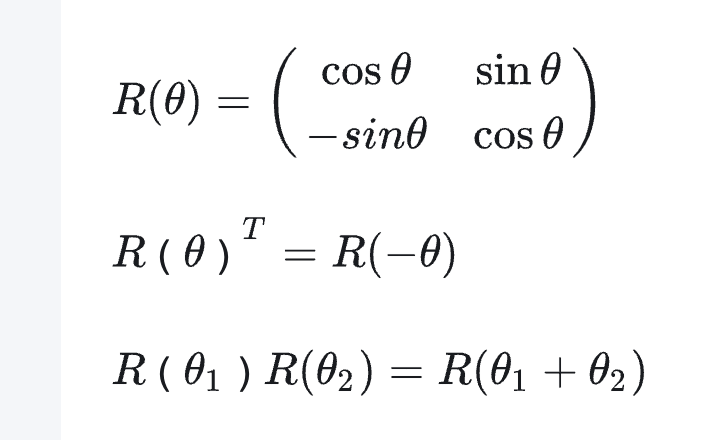

RoPE是对向量进行旋转之后输入注意力进行计算的，所以注意力计算的过程中也包含了相对位置信息，但是transformer里的位置信息是在外面算好加上去的，没有参与到注意力的计算中去

RoPE 具有更好的外推性

外推性是指大模型在训练时和预测时的输入长度不一致，导致模型的泛化能力下降的问题。例如，如果一个模型在训练时只使用了512个 token 的文本，那么在预测时如果输入超过512个 token，模型可能无法正确处理。这就限制了大模型在处理长文本或多轮对话等任务时的效果

对于高维向量，我们用矩阵乘法是很低效的，所以我们换一种优化的计算方法

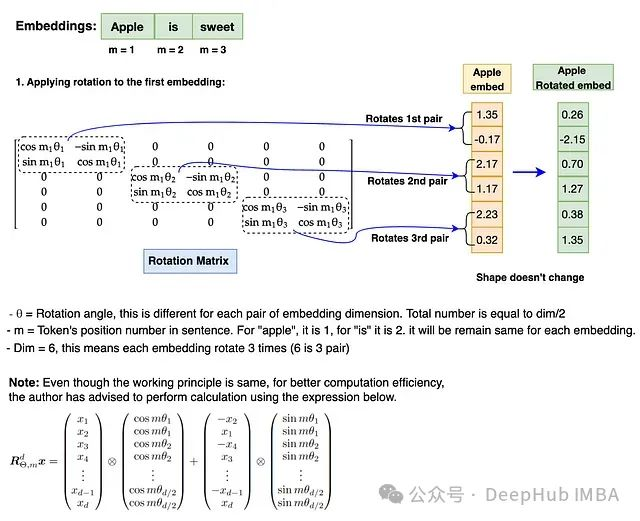


在实际的代码计算中，我们事实上是全部使用复数进行计算,两两组合变成复数
在复数域的视角看，就是我生成了一个角度，然后用这个角度做单位向量，用这个去乘就让其角度变化（欧拉公式，从指数的角度去看）

$$
(x_1+ix_2)(\cos \theta + i\sin \theta)=(x_1 \cos \theta -x_2 \sin \theta) +i(x_1\sin \theta +x_2 \cos \theta)
$$

In [25]:
def precompute_freqs_cis(dim,seq_len,theta=10000.0):  #此theta非彼theta，是一个超参数用来算旋转矩阵
    device=ModelArgs.device      #torch.arange(start,end,step)返回一个1维张量，包含在区间start和end之间，以step为步长的一组序列值
    freqs=1.0/torch.pow(theta,torch.arange(0,dim,2,device=device)[:(dim//2)]/dim)  #dim//2的意思是dim整除2，这样切片保证是一对一对的
    
    t=torch.arange(seq_len,device=device,dtype=torch.float32) #生成一个长度为seq_len的张量,表示的是在局内的序号位置
    freqs=torch.outer(t,freqs)  #外积，生成一个seq_len*dim//2的矩阵   得到的是 m/（10000.0^(2i/D) ） 这个矩阵 我们用这个作为角度
    #转化成复数
    freqs_cis=torch.polar(torch.ones_like(freqs),freqs).to(device) #polar函数返回的是一个张量，包含了频率的幅度和相位
    return freqs_cis
 #shape是（seq_len,dim//2）的张量，元素是复数
 
 
def reshape_for_broadcast(freqs_cis,x):
    ndim=x.ndim     #先确认维度，是为了处理多头注意力，多头注意力就是在dim上切片，然后把切片分别计算的结果拼接起来
    assert 1<ndim
    assert freqs_cis.shape==(x.shape[1],x.shape[-1]),"freqs_cis shape does not match x"  #assert后面跟个逗号和一句话，表示如果前面的条件不满足，就会报错，后面的话是报错的内容
    shape =[d if i==1 or i==ndim-1 else 1 for i,d in enumerate(x.shape)]  #这个是为了把freqs_cis的张量维度扩展到和x一样,对于第二个维度和最后一个维度要和x一样，这样就可以进行计算，其他维度都是1,这样就可以进行广播就会在运算的时候进行广播，复制好几份分别去计算
    return freqs_cis.reshape(*shape)  #返回一个和x一样维度的张量
 
def apply_rotary_emb(xq,xk,freqs_cis):
     device=ModelArgs.device
     xq_=torch.view_as_complex(xq.float().reshape(*xq.shape[:-1],-1,2)).to(device)  #把xq转化成复数，*xq.shape[:-1]表示生成最后一个维度之外的所有维度的大小,然后最后一个维度俩俩组合变成n*2格式，然后就能变成复数
     xk_=torch.view_as_complex(xk.float().reshape(*xk.shape[:-1],-1,2)).to(device)
     
     freqs_cis=reshape_for_broadcast(freqs_cis,xq_)
     #把freqs_cis的维度扩展到和xq一样
     
     xq_output=torch.view_as_real(xq_*freqs_cis).flatten(3).to(device)  #把xq和freqs_cis进行元素乘法（就是我们上面那张图上说的），flatten(3)是把从第四维度开始的维度都合并在一起，这样就和原来一样了
     xk_output=torch.view_as_real(xk_*freqs_cis).flatten(3).to(device)
     
     return xq_output.type_as(xq),xk_output.type_as(xk)  #返回的是经过旋转矩阵处理后的xq和xk
  
  
  


In [26]:
head_dim = ModelArgs.dim//ModelArgs.n_heads
wq = nn.Linear(ModelArgs.dim, ModelArgs.n_heads * head_dim, bias=False, device=device) 
wk = nn.Linear(ModelArgs.dim, ModelArgs.n_kv_heads * head_dim, bias=False, device=device) 
xq = wq(x_norm) 
xk = wk(x_norm) 
print(f"xq.shape: {xq.shape}") 
print(f"xk.shape: {xk.shape}") 
xq = xq.view(xq.shape[0],xq.shape[1],ModelArgs.n_heads, head_dim) 
xk = xk.view(xk.shape[0],xk.shape[1],ModelArgs.n_kv_heads, head_dim) 
freqs_cis = precompute_freqs_cis(dim=head_dim, seq_len=ModelArgs.max_seq_len) 
xq_rotate, xk_rotate = apply_rotary_emb(xq, xk, freqs_cis) 
print(f"xq_rotate.shape: {xq_rotate.shape}") 
print(f"xk_rotate.shape: {xk_rotate.shape}") 

xq.shape: torch.Size([10, 256, 512])
xk.shape: torch.Size([10, 256, 256])
xq_rotate.shape: torch.Size([10, 256, 8, 64])
xk_rotate.shape: torch.Size([10, 256, 4, 64])


In [27]:
torch.polar(torch.ones_like(x), x)
x=torch.randn(10,30,40)
x=x.reshape(*x.shape[:-1],-1,2)
xc=torch.view_as_complex(x)
xc
xr=torch.view_as_real(xc)
re=xr.flatten(2)
re.shape

torch.Size([10, 30, 40])

## kv缓存（用于推理）



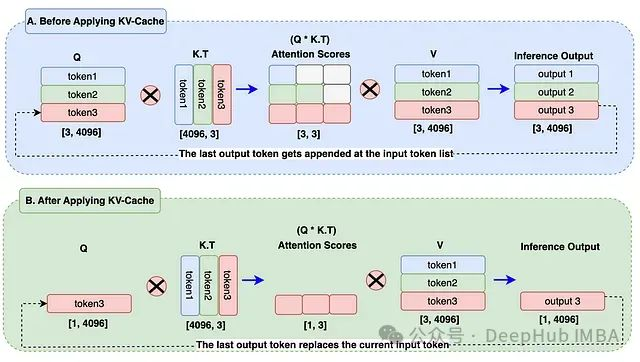

使用kv缓存把之前的kv存起来，就不用做更多的冗余计算了

但是带来了更多储存的问题，为了减少占用的空间，我们采用分组查询注意力，多个q对应一个key


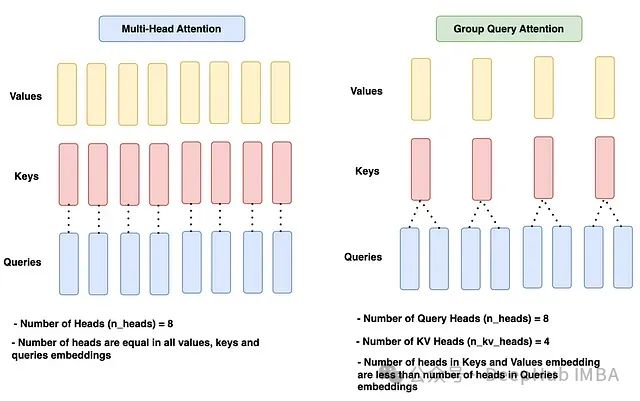


In [28]:

class Attention(nn.Module):
    def __init__(self,args):
        super().__init__()
        self.args=args
        self.device=args.device
        self.dim=args.dim
        self.n_heads=args.n_heads
        self.head_dim=self.dim//self.n_heads
        self.n_kv_heads=args.n_kv_heads
        self.n_rep=self.n_heads//self.n_kv_heads 
        
        
        self.wq=nn.Linear(self.dim,self.n_heads*self.head_dim,bias=False,device=device)
        self.wk=nn.Linear(self.dim,self.n_kv_heads*self.head_dim,bias=False,device=device)
        self.wv=nn.Linear(self.dim,self.n_kv_heads*self.head_dim,bias=False,device=device)
        self.wo=nn.Linear(self.dim,self.dim,bias=False,device=device)
        
        #kv缓存实现
        self.cache_k=torch.zeros(args.max_batch_size,args.max_seq_len,self.n_kv_heads,self.head_dim,device=device)
        self.cache_v=torch.zeros(args.max_batch_size,args.max_seq_len,self.n_kv_heads,self.head_dim,device=device)
        
        

        
    def forward(self,x,start_pos,inference=False):  #inference表示
        bsz,seq_len,_=x.shape
        mask=None
        
        xq=self.wq(x)
        xk=self.wk(x)
        xv=self.wv(x)
        
        xq = xq.view(bsz,seq_len,self.n_heads,self.head_dim)
        xk = xk.view(bsz,seq_len,self.n_kv_heads,self.head_dim)
        xv = xv.view(bsz,seq_len,self.n_kv_heads,self.head_dim)
        
        #推理模式下，我们需要使用缓存的kv
        if inference:
            #旋转位置编码的对象是每个头
            freq_cis=precompute_freqs_cis(dim=self.head_dim,seq_len=self.args.max_seq_len*2)  #还是没懂这一步到底想要干什么,为什么要乘以2,我猜测是为了保证位置够
            freq_cis=freq_cis[start_pos:start_pos+seq_len]
            xq,xk=apply_rotary_emb(xq,xk,freq_cis)
            
            self.cache_k=self.cache_k.to(xq)
            self.cache_v=self.cache_v.to(xq)  #将kv的缓存移动到和q一样的设备上
            self.cache_k[:bsz,start_pos:start_pos+seq_len]=xk
            self.cache_v[:bsz,start_pos:start_pos+seq_len]=xv  #这里在更新我们的缓存了
            
            keys=self.cache_k[:bsz,:start_pos+seq_len]
            values=self.cache_v[:bsz,:start_pos+seq_len]
            
            #让keys和values的维度和xq一样
            keys=repeat_kv(keys,self.n_rep)
            values=repeat_kv(values,self.n_rep)
            
        else:   #没用kv缓存
            freq_cis=precompute_freqs_cis(dim=self.head_dim,seq_len=self.args.max_seq_len)
            xq,xk=apply_rotary_emb(xq,xk,freq_cis)
            
            keys=repeat_kv(xk,self.n_rep)
            values=repeat_kv(xv,self.n_rep)
            
            #训练模式计算掩码
            mask=torch.full((seq_len,seq_len),float("-inf"),device=self.device) #初始化为全是-inf
            mask=torch.triu(mask,diagonal=1).to(self.device)  #
            
        
        xq=xq.transpose(1,2)  #把heads和seq_len的维度交换
        keys=keys.transpose(1,2)
        values=values.transpose(1,2)
        
        scores=F.softmax((torch.matmul(xq,keys.transpose(-2,-1))/math.sqrt(self.head_dim)).float(),dim=-1).type_as(xq)
        output=torch.matmul(scores,values).to(device)
        
        
        #得到了每个头部的
        output=output.transpose(1,2).contiguous().view(bsz,seq_len,-1)
        
        return self.wo(output)
    
    
    
def repeat_kv(x,n_rep):
    bsz,seq_len,n_heads,head_dim=x.shape
    if n_rep==1:
        return x
        
    x=x.view(bsz,seq_len,n_heads,head_dim)
    x=x.repeat_interleave(n_rep,dim=2)
    return x.view(bsz,seq_len,n_heads*n_rep,head_dim)
        
        
        
        
        
        
        




In [29]:
mask1=torch.full((10,10),float("-inf")) #初始化为全是-inf
mask2=torch.triu(mask1,diagonal=1)  #
mask1
mask2

tensor([[0., -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf],
        [0., 0., -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf],
        [0., 0., 0., -inf, -inf, -inf, -inf, -inf, -inf, -inf],
        [0., 0., 0., 0., -inf, -inf, -inf, -inf, -inf, -inf],
        [0., 0., 0., 0., 0., -inf, -inf, -inf, -inf, -inf],
        [0., 0., 0., 0., 0., 0., -inf, -inf, -inf, -inf],
        [0., 0., 0., 0., 0., 0., 0., -inf, -inf, -inf],
        [0., 0., 0., 0., 0., 0., 0., 0., -inf, -inf],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., -inf],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])

In [30]:
x_norm

tensor([[[-1.0007e+00,  1.5673e+00, -7.8597e-01,  ...,  1.3576e+00,
           7.3357e-01, -1.0137e+00],
         [ 3.2756e-01, -1.4180e-01, -5.7230e-03,  ...,  2.3754e-01,
           5.7759e-01, -1.1052e-01],
         [ 1.4246e+00,  3.9692e-01, -4.1379e-01,  ...,  6.5111e-01,
          -1.0014e+00,  1.1221e+00],
         ...,
         [-7.5628e-01, -3.9102e-01,  1.1790e+00,  ...,  1.1443e+00,
           1.5941e+00,  4.8610e-01],
         [ 2.9867e-01,  3.3246e-01,  5.3831e-01,  ..., -9.3795e-02,
          -4.2585e-02, -2.2506e-01],
         [-9.3018e-01, -2.5192e+00, -2.8010e-01,  ...,  4.2146e-01,
           1.4910e+00,  5.2136e-01]],

        [[ 9.5720e-02, -3.5516e-01, -7.0507e-01,  ...,  3.9449e-02,
          -3.8278e-01,  1.5420e+00],
         [ 1.7767e-01, -1.6003e+00,  9.2083e-01,  ..., -1.0174e-01,
           2.1714e-01, -4.2170e-01],
         [ 1.0473e+00, -7.4407e-02, -2.7885e-01,  ...,  8.2185e-01,
           4.1585e-01, -4.1722e-01],
         ...,
         [ 1.3617e+00,  1

## SwiGLU激活函数

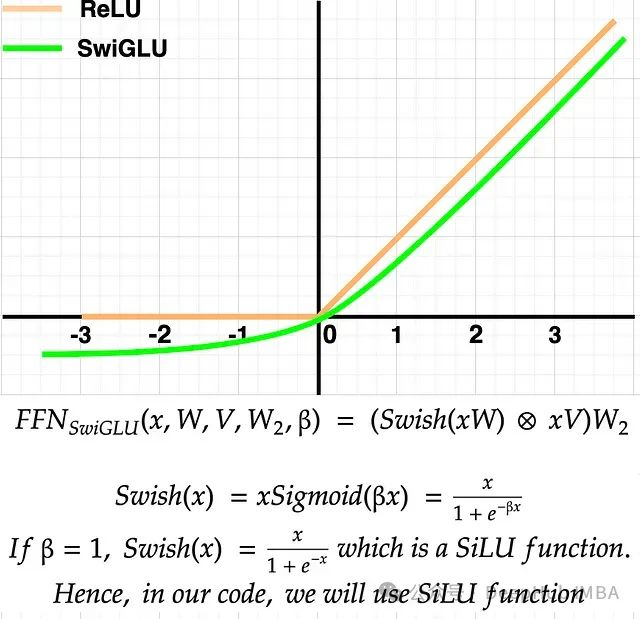

In [31]:
class FeedForward(nn.Module)              : 
    def   __init__(self, dim, hidden_dim,multiple_of,ffb_dim_multiplier:Optional[float]): 
        super().__init__() 
        self.dim = dim

        hidden_dim = int(2*hidden_dim/3)
        if ffb_dim_multiplier is not None: 
            hidden_dim = int(hidden_dim*ffn_dim_multiplier)
        hidden_dim = multiple_of*((hidden_dim+multiple_of-1)//multiple_of)
        
        #这些操作通过调整维度，使其公适应gpu的计算效率

        self.W1 = nn.Linear(self.dim,hidden_dim,bias=False).to(device)
        self.W2 = nn.Linear(hidden_dim,self.dim,bias=False).to(device)
        self.W3 = nn.Linear(self.dim,hidden_dim,bias=False).to(device)
        
    def forward(self,x): 
        return self.W2(F.silu(self.W1(x)) * self.W3(x))  

 



In [32]:
class TransformerBlock(nn.Module): 
    def   __init__(self,args)        : 
        super().__init__() 
        self.args           = args
        self.device         = args.device
        self.dim            = args.dim
        self.ffb            = FeedForward(dim=self.dim,hidden_dim=self.dim*4,multiple_of=args.multiple_of,ffb_dim_multiplier=args.ffn_dim_multiplier)
        self.attn           = Attention(args)
        self.ff_norm        = RMSNorm(dim=self.dim,eps=args.norm_eps)
        self.attention_norm = RMSNorm(dim=self.dim,eps=args.norm_eps)
        
    def forward(self,x,start_pos,inference=False): 
        h = x+self.attn(self.attention_norm(x),start_pos,inference)
        
        out = h+self.ffb(self.ff_norm(h))
        
        return out


    #注意力的输出和原始输出相加，同样还有一个经过前馈网络再和原始输出相加
    #这两个都属于是


In [33]:
x   = torch.randn(ModelArgs.max_batch_size, ModelArgs.max_seq_len,ModelArgs.dim).to(ModelArgs.device)
tb  = TransformerBlock(ModelArgs)
out = tb(x,0)
out.shape

torch.Size([10, 256, 512])

# 模型主体构建



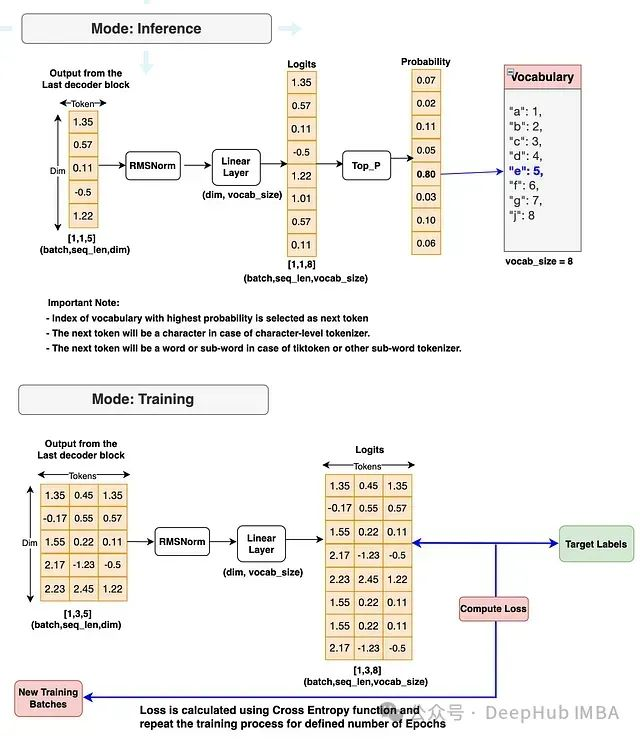

推理模式用top_p生成
训练模式就是算loss

In [34]:
class Transformer(nn.Module)         : 
    def   __init__(self,params:ModelArgs):  #:后的注解不影响代码运行，只是给人看的
       super().__init__()
       self.params  = params
       self.tok_emb = nn.Embedding(params.vocab_size,params.dim)
       
       self.layers = nn.ModuleList()
       for layer_id in range(params.n_layers): 
           self.layers.append(TransformerBlock(params))

       self.norm = RMSNorm(dim=params.dim,eps=params.norm_eps)

       self.output = nn.Linear(params.dim,params.vocab_size,bias=False)
        
    def forward(self,x,start_pos=0,target=None): 
        h = self.tok_emb(x)
        h = self.norm(h)

        inference = target is None
        for layer in self.layers: 
            h = layer(h,start_pos,inference)

        h = self.norm(h)
      

        logits = self.output(h).float()   #线性层的任务是生成将嵌入映射到词汇表大小的logits

        loss = None
        
        if target is not None: #训练模式
            loss = F.cross_entropy(logits.view(-1,self.params.vocab_size),target.view(-1))
            #entroy的损失函数里就有softmax，所以这里不用再加softmax
        else: 
            loss = None
            
        return logits,loss
     
        
    

In [35]:
model = Transformer(ModelArgs).to(ModelArgs.device)
print(model)

Transformer(
  (tok_emb): Embedding(68, 512)
  (layers): ModuleList(
    (0-7): 8 x TransformerBlock(
      (ffb): FeedForward(
        (W1): Linear(in_features=512, out_features=1536, bias=False)
        (W2): Linear(in_features=1536, out_features=512, bias=False)
        (W3): Linear(in_features=512, out_features=1536, bias=False)
      )
      (attn): Attention(
        (wq): Linear(in_features=512, out_features=512, bias=False)
        (wk): Linear(in_features=512, out_features=256, bias=False)
        (wv): Linear(in_features=512, out_features=256, bias=False)
        (wo): Linear(in_features=512, out_features=512, bias=False)
      )
      (ff_norm): RMSNorm()
      (attention_norm): RMSNorm()
    )
  )
  (norm): RMSNorm()
  (output): Linear(in_features=512, out_features=68, bias=False)
)


# 训练模型



## dataset


In [36]:
dataset = torch.tensor(encode(data),dtype=torch.int,device=ModelArgs.device)

print(f"dataset.shape: {dataset.shape}")  #f-string的写法，引号内是文字，{}内是变量，可以用各种表达式计算，类似bash

def get_dataset_batch(data,split,args): 
    seq_len    = args.max_seq_len
    batch_size = args.max_batch_size
    device     = args.device

    train = data[:int(0.8*len(data))]  #训练集
    val   = data[int(0.8*len(data)):int(0.9*len(data))]  #验证集，用于模型超参数调整和评估
    test  = data[int(0.9*len(data)):] #测试集

    batch_data =  train
    if   split      == "val":
        batch_data =  val
    elif split      == "test":
        batch_data =  test
        
    ix = torch.randint(0,len(batch_data)-seq_len-3,(batch_size,)) #生成barch_size个随机数，用于选择数据集中的位置
    #(batch_size,)是一个单元素元组，用于应对函数输入是元组的情况
    x = torch.stack([torch.cat([token_bos,batch_data[i:i+seq_len-1]]) for i in ix]).long().to(device)
    y = torch.stack([torch.cat([batch_data[i+1:i+seq_len],token_eos]) for i in ix]).long().to(device)
    return x, y
    







dataset.shape: torch.Size([1115394])


In [37]:
xs,ys = get_dataset_batch(dataset,"train",ModelArgs)
xs

tensor([[65, 43, 54,  ..., 51,  1, 39],
        [65, 46, 43,  ..., 53,  1, 52],
        [65,  0, 20,  ..., 11,  0, 35],
        ...,
        [65, 19, 56,  ..., 57,  1, 47],
        [65, 43, 39,  ..., 59, 43, 56],
        [65, 39,  1,  ..., 46, 39, 58]], device='cuda:5')

In [38]:
#使用pytorch的dataset和dataloader来加载数据
#dataset只需要实现ini，__len__和__getitem__，你可以写collate_fn来处理batch这将会被dataloader调用
#如果数据集中的样本包含不同长度的序列，那么可能需要一个自定义的 collate_fn 来处理这些序列的批量
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence

class TextDataset(Dataset): 
    def __init__(self,args,data,split,bos,eos):
        self.seq_len    =  args.max_seq_len
        self.batch_size =  args.max_batch_size
        self.device     =  args.device
        self.data       =  data
        self.train      =  data[:int(0.8*len(data))]  #训练集
        self.val        =  data[int(0.8*len(data)):int(0.9*len(data))]  #验证集，用于模型超参数调整和评估
        self.test       =  data[int(0.9*len(data)):] #测试集
        if   split           == "train":
            self.batch_data =  self.train
        elif split           == "val":
            self.batch_data =  self.val
        elif split           == "test":
            self.batch_data =  self.test
        self.token_bos  =  bos
        self.token_eos  =  eos


    def __len__(self): 
        return len(self.batch_data)-self.seq_len-3


    def __getitem__(self,idx): 

        end_idx   = idx + self.seq_len
        if end_idx >= self.__len__():
            raise IndexError("Index out of range")
        x = torch.cat([self.token_bos,self.batch_data[idx:idx+self.seq_len-1]]).long().to(device)
        y = torch.cat([self.batch_data[idx+1:idx+self.seq_len],self.token_eos]).long().to(device)

        return x, y





        

        

In [39]:
  dataset_train = TextDataset(ModelArgs,dataset, split='train',bos=token_bos,eos=token_eos)
  train_loader  = DataLoader(dataset_train, batch_size=ModelArgs.max_batch_size, shuffle=True)
x, y            = next(iter(train_loader))
print(x)

tensor([[65, 47, 52,  ...,  7,  7,  0],
        [65, 40, 53,  ..., 42,  1, 54],
        [65, 42,  1,  ..., 48, 59, 57],
        ...,
        [65, 53, 59,  ...,  6,  0, 31],
        [65, 53,  1,  ..., 41, 58, 59],
        [65, 35, 46,  ..., 43, 42,  1]], device='cuda:5')


## evaluation

In [40]:
#装饰器，传入装饰器的是下面的函数
#作用是在执行主函数之前，先执行某个预函数
@torch.no_grad()
def evaluate_loss(model,args):         #计算和储存训练和验证集上的损失，用于日志记录和绘图
    out = {}
    model.eval()

    for split in["train","val"]: 
        losses = []
        for _ in range(10): 
            xb,yb   = get_dataset_batch(dataset,split,args)
            _ ,loss = model(x=xb,target=yb)
            losses.append(loss.item())   #loss.item是从张量中提取出标量值的操作
        out[split] = np.mean(losses)


    model.train()
    return out





## train

In [41]:
def train(model,optimizer,args): 
    epochs       = args.epochs
    log_interval = args.log_interval
    device       = args.device
    losses       = []
    start_time   = time.time()

    

    for epoch in range(epochs): 
        #优化器梯度清零，得到批次数据
        optimizer.zero_grad()

        xs,ys = get_dataset_batch(dataset,"train",args)
        xs = xs.to(device)
        ys = ys.to(device)
        logits,loss=model(x=xs,target=ys)#前向传播，模型计算
        loss.backward()#反向传播
        optimizer.step() #更新参数
        if epoch % log_interval == 0:
           batch_time           =  time.time()-start_time
           x                    =  evaluate_loss(model,args)
           losses.append(x)
           print(f"Epoch {epoch}|val loss{x['val']}|train_loss{x['train']}|time:{batch_time}")
           start_time = time.time()

    print("验证损失:",losses[-1]["val"])
    plt.plot([x["val"] for x in losses],label="val")
    plt.plot([x["train"] for x in losses],label="train")
    plt.legend()
    plt.show()

    torch.save(model.state_dict(),"model.pth")
    print("模型已保存")

    

Epoch 0|val loss4.439093732833863|train_loss4.453287029266358|time:0.2922070026397705
Epoch 10|val loss3.065931034088135|train_loss3.0521377325057983|time:1.2277617454528809
Epoch 20|val loss2.9330230951309204|train_loss2.9147223234176636|time:0.928530216217041
Epoch 30|val loss2.0643499374389647|train_loss2.0077632188797|time:0.8761353492736816
Epoch 40|val loss0.5120653510093689|train_loss0.5055887371301651|time:1.1775851249694824
Epoch 50|val loss0.11953120529651642|train_loss0.1219302698969841|time:1.1633667945861816
Epoch 60|val loss0.038552889972925185|train_loss0.03878646679222584|time:1.2985405921936035
Epoch 70|val loss0.027367480285465717|train_loss0.026717985048890114|time:1.0904786586761475
Epoch 80|val loss0.018502066284418105|train_loss0.020356466993689537|time:1.322728157043457
Epoch 90|val loss0.016778220888227224|train_loss0.019206500612199306|time:1.2095015048980713
Epoch 100|val loss0.015938416309654712|train_loss0.017820990178734064|time:1.0379633903503418
Epoch 110

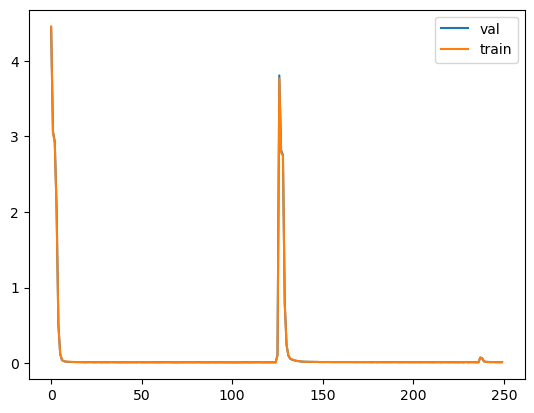

模型已保存


In [42]:
model     = Transformer(ModelArgs).to(ModelArgs.device)
optimizer = torch.optim.Adam(model.parameters())
train(model,optimizer,ModelArgs)

# Inference



In [44]:
def generate(model,prompts,params:ModelArgs,max_gen_len,temperature=0.6,top_p=0.9): 
#   top_p: 从logits采样prob输出的top-p概率阈值。默认为0.9
    bsz                  = 1
    prompt_tokens        = token_bos.tolist()+encode(prompts)
    assert len(prompt_tokens) <= params.max_seq_len, "Prompt is too long"
    total_len            = min(len(prompt_tokens)+max_gen_len,params.max_seq_len)
    #长度是prompt长度+生成长度和最大生成长度的最小值

    tokens = torch.full((bsz,total_len),fill_value=token_pad.item(),dtype=torch.long,device=params.device)
#初始化tokens，全是pad
    tokens[:,:len(prompt_tokens)] = torch.tensor(prompt_tokens,dtype=torch.long,device=params.device)

    input_text_mask = (tokens != token_pad.item())
    #把空白的mask掉

    prev_pos = 0
    for  cur_pos in range(1,total_len): 
        with torch.no_grad()             :   #我们在使用model的时候就会计算梯度，如果是推理阶段，不需要梯度，就直接no_grad
            logits,_ = model(x=tokens[:,prev_pos:cur_pos],start_pos=prev_pos)
        if temperature>0: 
            probs      = torch.softmax(logits[:,-1]/temperature,dim=-1)
            next_token = sample_top_p(probs,top_p)
        else: 
            next_token = torch.argmax(logits[:,-1],dim=-1)

        next_token = next_token.reshape(-1)

        next_token=torch.where(input_text_mask[:,cur_pos],tokens[:,cur_pos],next_token)
      #torch.where(condition,x,y)是一个三元运算符，如果condition是true，就返回x，否则返回y
        #这里就是看是不是pad，如果是pad就更新，用我算的代替，不是就不更新
        #因为 我前面model算的时候是从0开始全算的
        tokens[:,cur_pos] = next_token

        prev_pos = cur_pos
            
        if tokens[:,cur_pos] == token_pad.item()and next_token == token_eos.item():
            break

    output_tokens,output_texts = [], []

    for i,toks in enumerate(tokens.tolist()): #张量转换为列表，这样就可以迭代
        if  token_eos.item() in toks: 
            eos_idx = toks.index(token_eos.item())
            toks    = toks[:eos_idx]
         #找到eos，并且从这里截断（防止结束之后还继续输出）
         #一个toks是一个句子

        output_tokens.append(toks)
        output_texts.append(decode(toks))
        
    return output_tokens, output_texts
        


def sample_top_p(probs,p): #采样的函数
    #就是取概率最大的一群，然后这些概率加起来大于某个值，剩下的不要了 
    probs_sort,prob_idx  = torch.sort(probs,dim=-1,descending=True) #对概率排序，同时得到排序后的索引
    probs_sum = torch.cumsum(probs_sort,dim=-1) #计算最后一个维度的累加和
    #如果 probs_sort 是 [0.4, 0.35, 0.2, 0.05]，那么 probs_sum 就是 [0.4, 0.75, 0.95, 1.0]。
    mask             = probs_sum-probs_sort>p   #给后面不要的打上mask
    probs_sort[mask] = 0.0
    probs_sort.div_(probs_sort.sum(dim=-1,keepdim=True)) #对剩下的概率归一化
    #.div_是inplace操作，就是直接在原来的张量上操作,div是除法
    next_token = torch.multinomial(probs_sort,1) #多项式分布采样
    #这里采样得到的索引是排序后的顺序的索引

    next_token = torch.gather(prob_idx,-1,next_token)#prob_idx是[1,0,2]排序后的原索引
    #这样可以得到原来的索引
    return next_token
    
    
    





    


    

In [47]:
model = Transformer(ModelArgs).to(ModelArgs.device)
model.load_state_dict(torch.load("/hpc_stor03/sjtu_home/chen.yang/study/llama3/model.pth"))
prompts      = "sahdjkaha"
output_tokens,output_texts = generate(model,prompts,ModelArgs,max_gen_len=100)
output_texts=output_texts[0].replace("<|begin_of_text|>","")
print(output_texts)

sahdjkahaoreaaooeaaooruesaoroe
